# **COVID-19 country vaccinations progress : exploratory analysis + data visualitation**
____
____

## Objectives

In this notebook we will deal with missing data. We will present the exploratory analysis of the vaccin progress around the world.____

____
____
## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import folium
import scipy

## Import dataset

In [48]:
df = pd.read_csv('country_vaccinations.csv')
# df = df[:100]
df.head(2)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...


____
____

## Understanding the data

In [3]:
df.dtypes

country                                 object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
daily_vaccinations_per_million         float64
vaccines                                object
source_name                             object
source_website                          object
dtype: object

In [4]:
df.shape

(4908, 15)

### **Missing data**

In [5]:
df.isna().sum()

country                                   0
iso_code                                316
date                                      0
total_vaccinations                     1715
people_vaccinated                      2190
people_fully_vaccinated                3063
daily_vaccinations_raw                 2214
daily_vaccinations                      160
total_vaccinations_per_hundred         1715
people_vaccinated_per_hundred          2190
people_fully_vaccinated_per_hundred    3063
daily_vaccinations_per_million          160
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

Quite a lot a missing data in this file.
The first cleanig we can do concerns 'total_vaccinations". Vaccinations being what we are trying to analyse if this data is missing, the orther feature are then irrelevant.

In [6]:
df = df.drop(df[df.total_vaccinations.isna()].index)

In [7]:
df.isna().sum()

country                                   0
iso_code                                218
date                                      0
total_vaccinations                        0
people_vaccinated                       498
people_fully_vaccinated                1349
daily_vaccinations_raw                  499
daily_vaccinations                      135
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred           498
people_fully_vaccinated_per_hundred    1349
daily_vaccinations_per_million          135
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

A bit better!
<br>
Total vaccinations & people vaccinated, as well as, total_vacinnations_per_hundred & people_vaccinated_per_hundred seems to be very similar. Maybe we can use one instead of the two. 
<br>
To verify the hypothesis that those distributions are similar we can chexk the correlation between those different feature and then p-values.

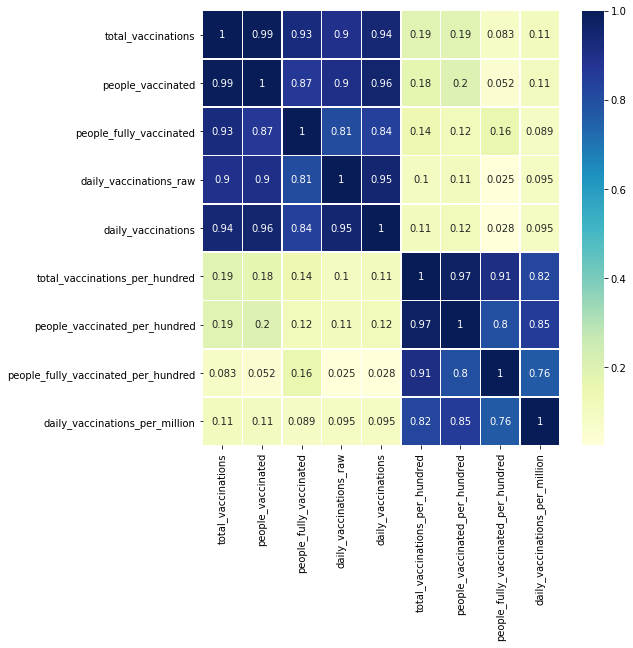

In [8]:
import seaborn as sns

plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot = True, linewidths = 0.5, cmap = "YlGnBu")
plt.show()

For : total vaccinations & people vaccinated, as well as, total_vacinnations_per_hundred & people_vaccinated_per_hundred we can observe very high correlation.
<br>
Are they the same distribution ? We can verufy this hypothesis using p-values

In [9]:
scipy.stats.mannwhitneyu(df.total_vaccinations, df.people_vaccinated, alternative = 'two-sided')

MannwhitneyuResult(statistic=4371386.0, pvalue=6.280720056615374e-23)

In [10]:
scipy.stats.mannwhitneyu(df.total_vaccinations_per_hundred, df.people_vaccinated_per_hundred, alternative = 'two-sided')

MannwhitneyuResult(statistic=4434823.5, pvalue=2.304122775254921e-19)

The p-values are way smaller than 0.05 so the hypothesis that those distribution are similar is wrong. Therefore we have to keep both distrution and fill the missing value using the mean of each of them.

In [11]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(df['people_vaccinated'].values.reshape(-1,1))
df['people_vaccinated'] = imputer.transform(df['people_vaccinated'].values.reshape(-1,1))

imputer.fit(df['total_vaccinations_per_hundred'].values.reshape(-1,1))
df['total_vaccinations_per_hundred'] = imputer.transform(df['total_vaccinations_per_hundred'].values.reshape(-1,1))

imputer.fit(df['people_vaccinated_per_hundred'].values.reshape(-1,1))
df['people_vaccinated_per_hundred'] = imputer.transform(df['people_vaccinated_per_hundred'].values.reshape(-1,1))

In [12]:
df.isna().sum()

country                                   0
iso_code                                218
date                                      0
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                1349
daily_vaccinations_raw                  499
daily_vaccinations                      135
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred    1349
daily_vaccinations_per_million          135
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

There are still some missing values,in people_fully_vaccinated, daily_vaccinations_raw, daily_vaccinations, people_fully_vaccinated_per_hundred and daily_vaccinations_per_million :
- daily_vaccinations_raw & daily_vaccinations are highly correlated
- people_fully_vaccinated_per_hundred & daily_vaccinations_per_million too
- and people_fully_vaccinated & people_fully_vaccinated_per_hundred too

Weare going to review the hypothesis that these distribution are the same, like before

In [13]:
scipy.stats.mannwhitneyu(df.daily_vaccinations_raw, df.daily_vaccinations, alternative = 'two-sided')

MannwhitneyuResult(statistic=5728856.5, pvalue=1.0435293847444265e-17)

The hypothesis is wrong. Let's fill the missing values with 0.

In [14]:
df.daily_vaccinations_raw = df.daily_vaccinations_raw.fillna(0)
df.daily_vaccinations = df.daily_vaccinations.fillna(0)

In [15]:
df.isna().sum()

country                                   0
iso_code                                218
date                                      0
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                1349
daily_vaccinations_raw                    0
daily_vaccinations                        0
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred    1349
daily_vaccinations_per_million          135
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

In [16]:
scipy.stats.mannwhitneyu(df.people_fully_vaccinated_per_hundred, df.daily_vaccinations_per_million, alternative = 'two-sided')

MannwhitneyuResult(statistic=4270376.5, pvalue=2.9052678022867946e-29)

Same here.

In [17]:
df.daily_vaccinations_per_million = df.daily_vaccinations_per_million.fillna(0)
df.people_fully_vaccinated_per_hundred = df.people_fully_vaccinated_per_hundred.fillna(0)

In [18]:
df.isna().sum()

country                                   0
iso_code                                218
date                                      0
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                1349
daily_vaccinations_raw                    0
daily_vaccinations                        0
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred       0
daily_vaccinations_per_million            0
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

In [19]:
scipy.stats.mannwhitneyu(df.people_fully_vaccinated, df.people_fully_vaccinated_per_hundred, alternative = 'two-sided')

MannwhitneyuResult(statistic=10190784.0, pvalue=0.0)

Same here too.

In [20]:
df.people_fully_vaccinated = df.people_fully_vaccinated.fillna(0)

The only missing values left are the iso code missing values. 
<br>
The missing values are : 

In [21]:
df[df.iso_code.isna()].country.unique()

array(['England', 'Northern Ireland', 'Scotland', 'Wales'], dtype=object)

We can associate the iso code the appropriate country

In [22]:
df[df.country == 'England'] = df[df.country == 'England'].fillna('GB-ENG')
df[df.country == 'Northern Ireland'] == df[df.country == 'Northern Ireland'].fillna('GB-NIR')
df[df.country == 'Scotland'] = df[df.country == 'Scotland'].fillna('GB-SCT')
df[df.country == 'Wales'] = df[df.country == 'Wales'].fillna('GB-WLS')
df = df.fillna('NC')

In [23]:
df.isna().sum()

country                                0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
source_name                            0
source_website                         0
dtype: int64

All missing data are handled !!
____
____

## Visualization
____

### Amount of vaccinated people

#### **Bar chart of the amount of vaccinated people**

In [24]:
cols = ['country', 'total_vaccinations', 'iso_code', 'vaccines', 'total_vaccinations_per_hundred']
vacc_amount = df[cols].groupby('country').max().sort_values('total_vaccinations', ascending=False)
vacc_amount = vacc_amount.reset_index()

In [25]:
vacc_amount.head()

,country,total_vaccinations,iso_code,vaccines,total_vaccinations_per_hundred
0,United States,78631601.0,USA,"Moderna, Pfizer/BioNTech",23.51
1,China,52520000.0,CHN,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",3.65
2,United Kingdom,21322717.0,GBR,"Oxford/AstraZeneca, Pfizer/BioNTech",31.41
3,England,17985951.0,GB-ENG,"Oxford/AstraZeneca, Pfizer/BioNTech",31.95
4,India,15620749.0,IND,"Covaxin, Oxford/AstraZeneca",1.13


In [26]:
vacc_amount.shape

(122, 5)

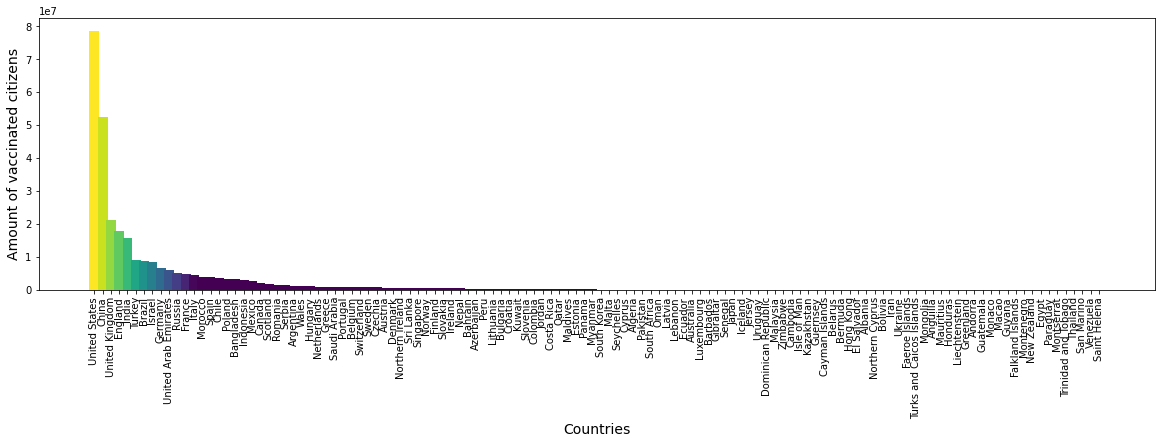

In [27]:
cm = plt.cm.get_cmap('viridis_r')
colors = [cm(10*val/(vacc_amount.shape[0])) for val in range((vacc_amount.shape[0]))]

fig, ax = plt.subplots(figsize = (20, 5))

bar1 = ax.bar(vacc_amount.country, vacc_amount.total_vaccinations, width = 1.2, align ='center', color = colors)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel('Amount of vaccinated citizens', fontsize = 14)
plt.xlabel('Countries', fontsize = 14)
plt.show()

#### **Folium world map of the amount of vaccinated people**

In [28]:
countries = vacc_amount['country']

In [29]:
from geopy.geocoders import Nominatim
import geocoder
#Define a get coordinates function
def get_latlng(countries):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis(countries)
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [30]:
coords = [ get_latlng(country) for country in countries ]

In [31]:
# coords[0:5]

In [32]:
coords = pd.DataFrame(coords)

In [33]:
latlong_country = pd.concat([countries, coords], axis = 1)
latlong_country['Latitude'] = latlong_country[0]
latlong_country['Longitude'] = latlong_country[1]
cols = [1,2]
latlong_country.drop(latlong_country.columns[cols],axis=1,inplace=True)
latlong_country.set_index('country', inplace = True)
latlong_country.head()

,Latitude,Longitude
country,,
United States,39.398703,-99.414619
China,36.567348,103.930027
United Kingdom,53.408387,-1.969560
England,52.592737,-1.458625
India,23.379380,79.443327


In [34]:
vacc_amount['Latitude'] = ''
vacc_amount['Longitude'] = ''

In [35]:
for country in countries:
    for i in range(len(countries)):
        for j in range(len(vacc_amount)):
            if country == vacc_amount['country'][j]:
                vacc_amount['Latitude'][j] = latlong_country.loc[country, 'Latitude']
                vacc_amount['Longitude'][j] = latlong_country.loc[country, 'Longitude']

In [36]:
# vacc_amount.head()

In [37]:
from folium.plugins import MarkerCluster

world_map= folium.Map(location=[-19.016205, 29.884277], tiles="cartodbpositron", zoom_start = 2)

#for each coordinate, create circlemarker of user percent
for i in range(len(vacc_amount)):
        lat = vacc_amount.iloc[i]['Latitude']
        long = vacc_amount.iloc[i]['Longitude']
        radius = 10 * (vacc_amount.iloc[i]['total_vaccinations']/1000)
        popup_text = """Country : {}<br>
                        Total vaccins : {}<br>"""
        popup_text = popup_text.format(vacc_amount.iloc[i]['country'],
                                   vacc_amount.iloc[i]['total_vaccinations'] )
        
        folium.Circle(location = [lat, long], radius=radius, color = 'green', popup= popup_text, fill =True).add_to(world_map)
world_map

<img src="amount_of_vaccinated_poeple.PNG">

____

### Amount of vaccinated citizens per hundred

#### **Bar chart of the amount of vaccinated citizens per hundred**

In [38]:
vacc_amount = vacc_amount.sort_values('total_vaccinations_per_hundred', ascending = False)
vacc_amount.head()

,country,total_vaccinations,iso_code,vaccines,total_vaccinations_per_hundred,Latitude,Longitude
75,Gibraltar,38056.0,GIB,Pfizer/BioNTech,112.96,36.136008,-5.348662
7,Israel,8315288.0,ISR,"Moderna, Pfizer/BioNTech",96.07,31.977712,34.979218
63,Seychelles,80131.0,SYC,"Oxford/AstraZeneca, Sinopharm/Beijing",81.48,-4.678652,55.467262
9,United Arab Emirates,6094956.0,ARE,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",61.62,23.91487,54.326858
111,Falkland Islands,1732.0,FLK,Oxford/AstraZeneca,49.73,-51.745506,-58.75211


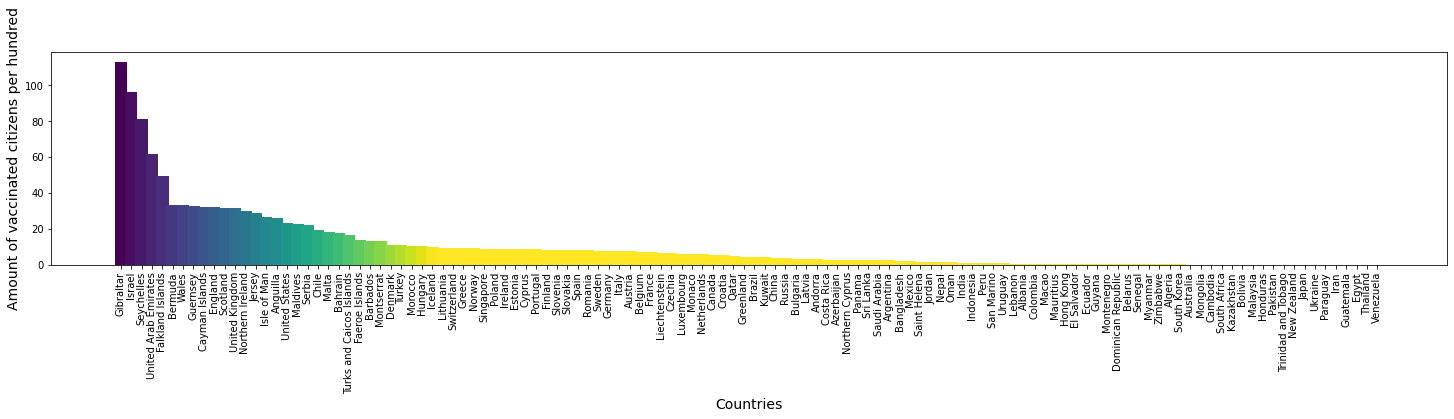

In [39]:
cm = plt.cm.get_cmap('viridis')
colors = [cm(val*4/(vacc_amount.shape[0])) for val in range((vacc_amount.shape[0]))]

fig, ax = plt.subplots(figsize = (20, 5))

bar1 = ax.bar(vacc_amount.country, vacc_amount.total_vaccinations_per_hundred, width = 1.2, align='center', color = colors)
plt.ylabel('Amount of vaccinated citizens per hundred', fontsize = 14)
plt.xlabel('Countries', fontsize = 14)
plt.xticks(rotation = 90, fontsize = 10)
plt.tight_layout(0.01)
plt.show()


#### **Folium world map of the amount of vaccinated citizens per hundred**

In [40]:
from folium.plugins import MarkerCluster

world_map = folium.Map(location =[-19.016205, 29.884277], tiles ="cartodbpositron", zoom_start = 3)

#for each coordinate, create circlemarker of user percent
for i in range(len(vacc_amount)):
        lat = vacc_amount.iloc[i]['Latitude']
        long = vacc_amount.iloc[i]['Longitude']
        radius = 10000 * (vacc_amount.iloc[i]['total_vaccinations_per_hundred']/5)
        popup_text = """Country : {}<br>
                        Total vaccins : {}<br>"""
        popup_text = popup_text.format(vacc_amount.iloc[i]['country'],
                                   vacc_amount.iloc[i]['total_vaccinations_per_hundred'] )
        
        folium.Circle(location = [lat, long], radius=radius, color = 'green', popup= popup_text, fill =True).add_to(world_map)
world_map

<img src= "amount_of_vaccinated_citizens_per_hundred.PNG">

____

### Most popular vaccins

In [41]:
vacc_pop = vacc_amount.groupby('vaccines').sum().sort_values('total_vaccinations', ascending=False)
vacc_pop = vacc_pop.reset_index()
vacc_pop.head()

,vaccines,total_vaccinations,total_vaccinations_per_hundred
0,"Moderna, Pfizer/BioNTech",91293435.0,160.69
1,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",52520000.0,3.65
2,"Oxford/AstraZeneca, Pfizer/BioNTech",44626273.0,234.20
3,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",31012030.0,151.56
4,"Covaxin, Oxford/AstraZeneca",15620749.0,1.13


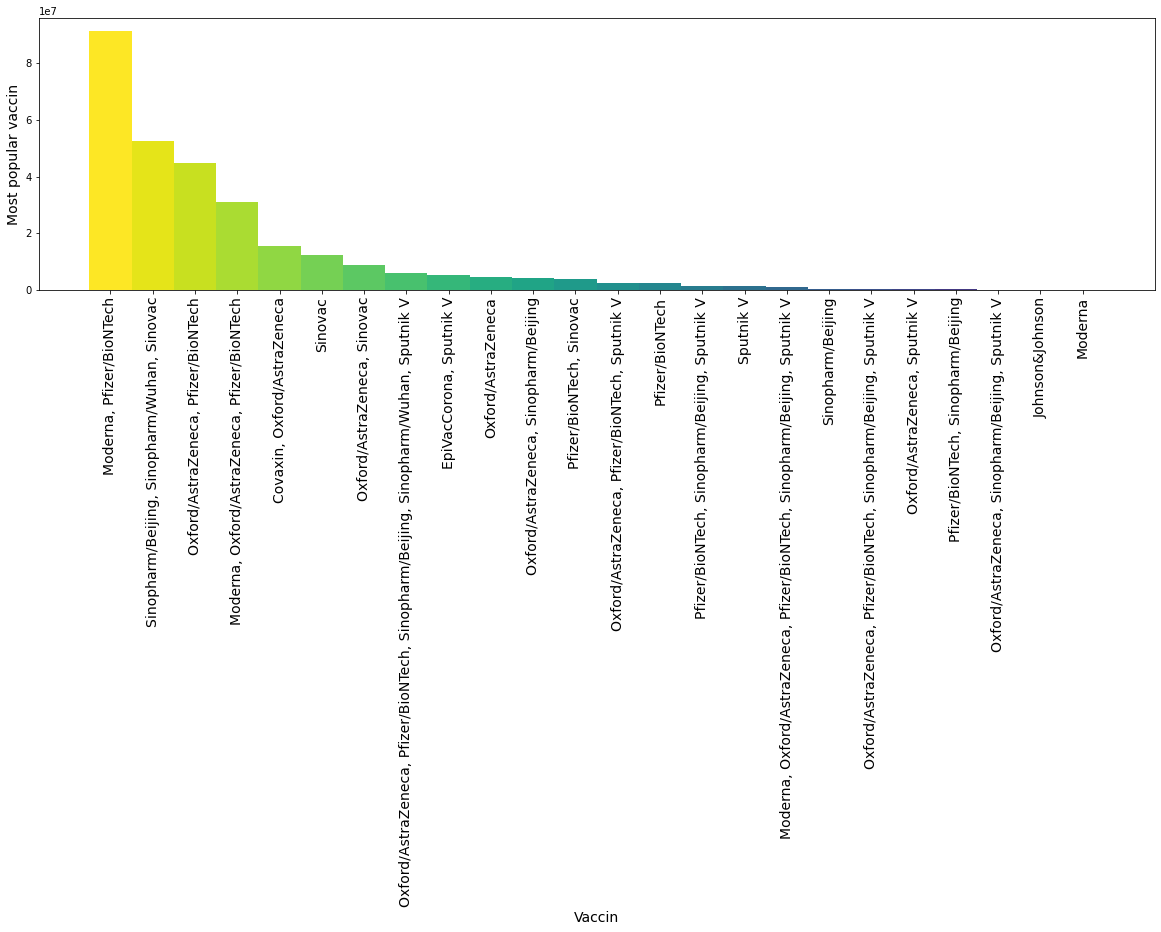

In [42]:
cm = plt.cm.get_cmap('viridis_r')
colors = [cm(val/(vacc_pop.shape[0])) for val in range((vacc_pop.shape[0]))]

fig, ax = plt.subplots(figsize = (20, 5))

bar1 = ax.bar(vacc_pop.vaccines, vacc_pop.total_vaccinations, align='center', width = 1, color = colors)
plt.xticks(rotation = 90, fontsize = 14)
plt.ylabel('Most popular vaccin', fontsize = 14)
plt.xlabel('Vaccin', fontsize = 14)
plt.show()